# Delivery-Analysis and Customer Retention

As a business owner of a restaurant I often find themselves navigating through a range of challenges including high operational costs, staffing, and tight profit margins. Attracting and retaining customers in a competitive market requires effective and strong marketing techniques. We want the best return on investment (ROI). Additionally, fluctuations in customer demand, seasonality, and economic downturns can impact revenue. The objective of this project is to help restaurant owners to gain data-driven insights. This project asses the deliveries of a restaurant to see how well marketing strategies of flyering neighbourhoods are doing each week. As well as the marketing, it focuses on customer retention by finding customers who have not ordered in 6 months time.  

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from geopy.geocoders import Nominatim
import time
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from IPython.display import IFrame
from IPython.display import display
import geojson
import geopandas as gpd
from shapely.geometry import Point


#Load the delivery data into 2 different data frames for each year
file_path = 'Data Deliveries.xlsx'
df_2024 = pd.read_excel(file_path, sheet_name='2024')
df_2025 = pd.read_excel(file_path, sheet_name='2025')


# Weekly Deliveries

We get the total number of deliveries for each week. Below, we are taking the 2024 and 2025 data. We can compare to see if the total number of deliveries are increasing or decreasing week to week. We do notice that with the data over the last 2 years the deliveries are lower at the beginning of the month and peak mid month. This can be rent and most bills are due near the beginning of the month so there is less disposable income. As well as mid month is usually when government cheques are issued. (ie. Income assistance and child tax credits) This can help us with scheduling.

In [47]:
def getWeeklyDeliveries():

    df = pd.concat([df_2024,df_2025], ignore_index=True)

    # Convert Date
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    # Extract year, week number, and start of week
    df['Year'] = df['Date'].dt.year
    df['Week_Num'] = df['Date'].dt.isocalendar().week
    df['Week_Start'] = df['Date'] - pd.to_timedelta(df['Date'].dt.dayofweek, unit='d')  # Start on Sunday

    # Extract month from Week_Start (ensures 1 value per week)
    df['Month'] = df['Week_Start'].dt.strftime('%B')

    # Count weekly deliveries
    weekly_counts = df.groupby(['Year', 'Week_Num']).size().reset_index(name='Deliveries')

    # Create a consistent `Week_Num -> Month` map using earliest week from any year
    month_map = df.groupby('Week_Num')['Month'].first().reset_index()
    df['Year'] = df['Year'].astype(int) #convert year to int from float
    # Pivot the delivery data
    pivot = weekly_counts.pivot(index='Week_Num', columns='Year', values='Deliveries')
    pivot.columns = [f'{col} Deliveries' for col in pivot.columns]
    pivot = pivot.reset_index()

    # Merge in Month label (no duplicates now)
    pivot = pivot.merge(month_map, on='Week_Num', how='left')

    # Reorder columns
    cols = ['Week_Num', 'Month'] + [col for col in pivot.columns if 'Deliveries' in col]
    pivot = pivot[cols]

    # Fill missing weeks with 0
    pivot = pivot.fillna(0).astype({col: 'int' for col in pivot.columns if 'Deliveries' in col})
    
    return pivot

getWeeklyDeliveries()

,Week_Num,Month,2024 Deliveries,2025 Deliveries
0,9,February,30,53
1,10,March,184,151
2,11,March,211,170
3,12,March,204,159
4,13,March,175,186
5,14,April,193,144
6,15,April,191,166
7,16,April,212,174
8,17,April,189,152
9,18,April,64,167


# Neighbourhood Incomes

We want to understand our delivery area. From the city website, we have gotten the household statisitcs for the neighbourhoods. We will overlay the average household income onto a map with the different neighbourhoods in our delivery area.

[View income_map.html](income_map.html)

In [46]:
# Load GeoJSON neighborhood data
gdf = gpd.read_file("neighbourhoods.geojson")

# Load CSV with income data
df_income = pd.read_csv("income_data.csv")  

#change the column name to match so you can merge the 2 dataframes
gdf = gdf.rename(columns={'neighbourhood':'Neighbourhood'}) 

# Merge on 'neighbourhood' column
gdf = gdf.merge(df_income, on='Neighbourhood', how='left')

# Check if data merged correctly
print(gdf[['Neighbourhood', 'Income']].head())

# Create folium map centered on Prince George
m = folium.Map(location=[53.9171, -122.7497], zoom_start=11)

# Add neighborhoods with color based on average income
folium.Choropleth(
    geo_data=gdf,
    name="choropleth",
    data=gdf,
    columns=["Neighbourhood", "Income"],
    key_on="feature.properties.Neighbourhood",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Average Income ($)"
).add_to(m)

# Add labels for each neighborhood
for _, row in gdf.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        centroid = row.geometry.centroid
        folium.map.Marker(
            [centroid.y, centroid.x],
            icon=folium.DivIcon(html=f"""
                <div style="
                    font-size: 12px;
                    color: black;
                    background-color: rgba(255, 255, 255, 0.6);
                    padding: 2px 4px;
                    border-radius: 3px;
                    border: 1px solid #999;">
                    {row['Neighbourhood']}<br>${int(row['Income']):,}
                </div>""")
        ).add_to(m)
m
# Save the map
m.save("income_map.html")
IFrame(src='income_map.html',width=700,height=700)

    Neighbourhood  Income
0  Hart Highlands  117718
1   North Nechako  123734
2       West Bowl  100371
3       East Bowl   73572
4  Cranbrook Hill  157139


# Identifying Deliveries per Neighbourhoods

We want to see the number of deliveries per neighbourhood. Essentially we want the high income areas to have high amount of deliveries. These are the customers with more disposable income and is premium targeting. 

With our data we see the we have high deliveries to the West and East Bowl neighbourhoods.They have the lowest total house incomes compared to other neighbourhoods.This may be due to the proximity to the restaurant and convenience. We will further investigate these neighbourhoods to see if they are susceptible to price sensitivity and more likely to churn.

We also notice that we have an opportunity to the Cranbrook Hill neighbourhood. They have the highest income yet they have the least amount of orders.

    Neighbourhood  delivery_count
0  Cranbrook Hill               5
1       East Bowl             557
2  Hart Highlands             348
3   North Nechako             125
4       West Bowl             835


<Axes: >

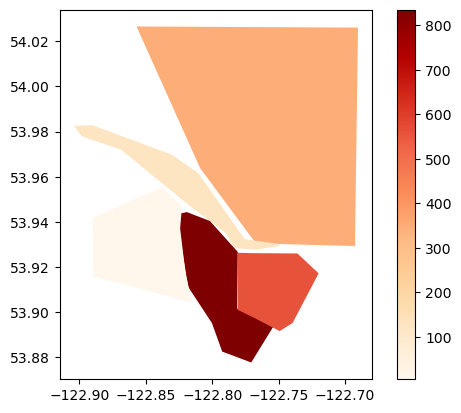

In [44]:
# Load the GeoJSON
gdf = gpd.read_file("neighbourhoods.geojson")

# Load income data
income_df = pd.read_csv("income_data.csv")

# Load delivery data
df_deliveries = pd.read_excel('geocoded_addresses.xlsx')

geometry = [Point(xy) for xy in zip(df_deliveries.longitude, df_deliveries.latitude)]
gdf_deliveries = gpd.GeoDataFrame(df_deliveries, geometry=geometry, crs=gdf.crs)

# Spatial join 
gdf_joined = gpd.sjoin(gdf_deliveries, gdf, how="left", predicate="within") #now each delivery is tagged with the neighbourhoods

# Count deliveries per neighborhood
delivery_counts = gdf_joined.groupby("neighbourhood").size().reset_index(name="delivery_count")
delivery_counts = delivery_counts.rename(columns={'neighbourhood':'Neighbourhood'})
print(delivery_counts)
# Merge delivery + income
merged_df = delivery_counts.merge(income_df, on="Neighbourhood")
gdf = gdf.rename(columns={'neighbourhood':'Neighbourhood'})

gdf_summary = gdf.merge(merged_df, on="Neighbourhood")
gdf_summary.plot(column="delivery_count",legend=True,cmap="OrRd")



# Plotting The Trends

We plot the deliveries comparing 2024 vs 2025. We want to see we are busier or slower then the previous year. As the comparison shows that the deliveries are down in comparison. This can be due to a numerous of reasons such as economic factors with interest rates rising, inflation or new competitors opening up. We can investigate further with mapping inactive customers who have not ordered from us in the past 6 months. 

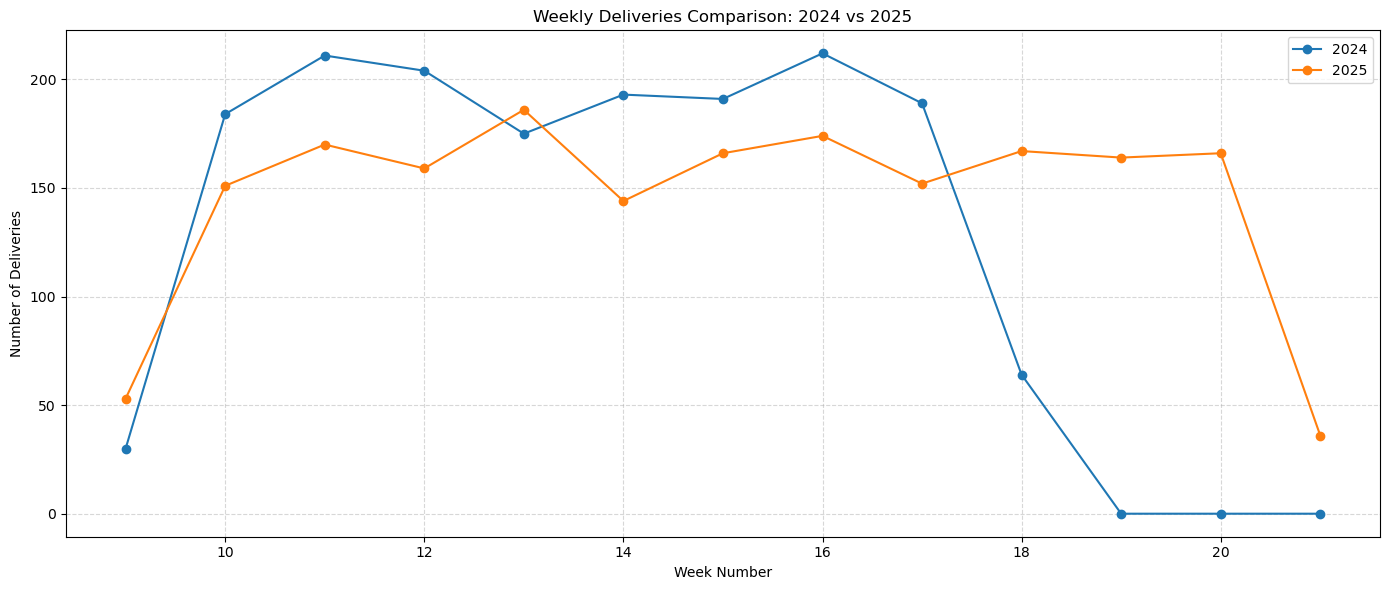

In [38]:
# Plot setup
pivot = getWeeklyDeliveries()
plt.figure(figsize=(14, 6))
plt.plot(pivot['Week_Num'], pivot['2024 Deliveries'], label='2024', marker='o')
plt.plot(pivot['Week_Num'], pivot['2025 Deliveries'], label='2025', marker='o')

plt.title('Weekly Deliveries Comparison: 2024 vs 2025')
plt.xlabel('Week Number')
plt.ylabel('Number of Deliveries')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



# Inactive Customers 

We also want to find out inactive customers who have not ordered from us in specified amount of time. This will help us with targeting those customers with perhaps special offers to get them to order again. We have decided to get all customers who have not ordered from us in the past 6 months. As well as we have decided we want customers who had ordered more then once before but now have not. We save the addresses into an excel file as well as the customers average ticket price. This will help us target what kind of promotion we want to offer the customer. For example, if the customer average ticket was over $70 dollars, we may want to include a larger discount to entice them to order again as they are likely ordering for a family.

In [4]:
#get inactive customers that have not ordered in the last 6 months
def getInactiveCustomers():
    '''
        Gets the inactive customers that have not ordered in the last 6 months
    '''
    # Combine both DataFrames
    df = pd.concat([df_2024, df_2025], ignore_index=True)
    # Ensure 'date' column is datetime type
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Remove any rows where date could not be parsed
    df = df.dropna(subset=['Date'])

    # Calculate the date 6 months ago from today
    six_months_ago = datetime.now() - pd.DateOffset(months=6)

    # Get the most recent order date per address
    last_order_per_address = df.groupby('Address')['Date'].max().reset_index()

    # Find addresses where the last order was more than 6 months ago
    inactive_customers = last_order_per_address[last_order_per_address['Date'] < six_months_ago]

    # Merge with original data to get full order history for inactive customers
    merged = pd.merge(inactive_customers[['Address']],df, on='Address',how='left')
    
    # Calculate order counts per address
    order_counts = merged.groupby('Address').size().reset_index(name='order_count')

    # Filter to only those customers who have ordered more than once
    multi_order_customers = order_counts[order_counts['order_count'] > 1]
    
    # Calculate average ticket price for these multi-order inactive customers
    avg_ticket_price = merged[merged['Address'].isin(multi_order_customers['Address'])] \
                    .groupby('Address')['Amount'].mean().reset_index().rename(columns={'Amount': 'avg_ticket_price'})
    

    inactive_customers = pd.merge(avg_ticket_price, last_order_per_address, on='Address')

    #save the inactive customers to excel file
    inactive_customers.to_excel('inactive_customers.xlsx', index=False)

getInactiveCustomers()

# Map Inactive Customers

We map the inactive customers to see if there a pattern of where customers have stopped ordering. This can help us identify the impact of perhaps new competitors opening up in certain areas. It can also help us spot economic trends in neighbourhoods that are susceptible to price sensitivity. As predicted earlier, the West and East Bowl have quite a large number of customers that have not ordered. We may decide to launch discounted specials in those areas to win them back

[View Inactive Customers.html](Inactive%20Customers.html)

In [86]:
def mapInactiveCustomers():
    '''
        Map the inactive customers to see a visual representation
    '''
    inactive_customers = pd.read_excel('inactive_customers.xlsx')
    addresses = list(inactive_customers['Address'])

    locations = get_locations(addresses)
    
    if locations:
        avg_lat = sum(lat for _, lat, _ in locations) / len(locations)
        avg_lon = sum(lon for _,_, lon in locations) / len(locations)
        m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)
    
        #add a marker at the specified addresses 
        for addr, lat, lon in locations:
            folium.Marker(location=[lat,lon], popup=addr).add_to(m)
        m.save("Inactive Customers.html")
        print("Map saved as Inactive Customers.html")
    else:
        print("No locations to map.")

#gets latitude and longitude of the address list
def get_locations(addresses):
    
    geolocator = Nominatim(user_agent="address_mapper")
    locations = []
    for address in addresses:
        try:
            location = geolocator.geocode(address)
            if location:
                locations.append((address, location.latitude, location.longitude))
        except Exception as e:
            continue #continue if address cannot be found
            #print(f"Error geocdoing {address}: {e}")
            
        time.sleep(2) #give a 2 second break inbetween api calls so we dont go over the limit of api
        
    return locations

mapInactiveCustomers()
IFrame(src='Inactive Customers.html',width=700,height=700)

Map saved as Inactive Customers.html


# Generate Heat Map

Lets generate a Heat Map of the deliveries for a specified week. The will let us know which areas of the city the customers are ordering in on a particular week. It will help us to see if promotional campaigns run in the area have succeeded. 

In [6]:
def generateHeatMap(start_of_week):
    
    df = df_2025
    df['Date'] = pd.to_datetime(df['Date'])

    start_date = pd.to_datetime(start_of_week)
    end_date = start_date + timedelta(days=6)

    df_week = df[(df['Date'] >= start_date) & (df['Date'] <= end_date) ]

    addresses = list(df_week['Address'])

    locations = get_locations(addresses)

    df_locations = pd.DataFrame(locations)
    df_locations = df_locations.rename(columns={0:'Address',1:'latitude',2:'longitude'})
    
    #merge the latitude and longitude
    df_week = df_week.merge(df_locations,on='Address',how='left')
    df_week = df_week.dropna(subset=['latitude', 'longitude'])

    map_center = [df_week['latitude'].mean(),df_week['longitude'].mean()]

    m = folium.Map(location=map_center, zoom_start=8)

    #generate heatmap
    heat_data = df_week[['latitude','longitude']]
    HeatMap(heat_data).add_to(m)

    m.save("delivery_heatmap.html")

#gets latitude and longitude of the address list
def get_locations(addresses):
    
    geolocator = Nominatim(user_agent="address_mapper")
    locations = []
    for address in addresses:
        try:
            location = geolocator.geocode(address)
            if location:
                locations.append((address, location.latitude, location.longitude))
        except Exception as e:
            continue #continue if address cannot be found
            #print(f"Error geocdoing {address}: {e}")
            
        time.sleep(2) #give a 2 second break inbetween api calls so we dont go over the limit of api
        
    return locations

generateHeatMap("2025-05-17")

# Heat Map

As you see the following heat map is generated. As you can see that deliveries occurred only in a small section of the city. There are concentrated areas where the majority of the deliveries occured and quite a large section where there were none. I would compare this heat map to where promotional campaigns (such as flyers) were run to see if they were a success. As well I would see the areas where little to no deliveries occured to focus on more flyering in those areas.

[View delivery_heatmap.html](delivery_heatmap.html)

In [20]:
IFrame(src='delivery_heatmap.html',width=700,height=700)

# Churn Prediction (Random Forest)

We now do a churn prediction to see which customers are likely to stop ordering. We will try identify at risk customers to preemptively take measures to stop them from churning. It will give each customer a probability score if they will churn or not. If the score is .6 or above, the customer is likley to churn. The customer churn probabilities are outputed to an excel file. 

We also print out the classification report. The classification report is how well our model is performing. 

| Metric    |  Meaning
|:----------|:------------------------------------------------------------------------------------------|
|Precision  |   Out of all the customers the model predicted would churn, how many actually did?        |
|Recall	    |   Out of all customers who actually churned, how many did the model correctly identify?   |
|F1-score   |   Harmonic mean of precision and recall — balances the two                                |
|Support    |   The number of actual instances in each class (e.g., how many churned)                   |


Class 0 is how many did not churn. Class 1 is how many churned. 


The ROC AUC score ranges between 0 to 1. It tells you how well the model can separate churners from non-churners based on probability. In our case below, the model gives higher probabilities to all churners than to non-churners. This means it is the perfect ranking -> ROC AUC = 1.0. 

The score table is as follows:

|Score |	Meaning                                    |
|:-----|:----------------------------------------------|
|1.0   |    Perfect separation — ideal model           |
|0.95  |	Excellent — almost always right            |
|0.85  |	Very good — ranks most churners correctly  |
|0.70  |	Fair — helpful, but room for improvement   |
|0.50  |	No skill — same as random guessing         |
|< 0.50|	Worse than guessing — probably inverted    |


In [7]:
def time_to_seconds(t):
    '''
        Convert time (ex, 14:30:00) into seconds since midnight

        Params: 
            The time 
        
        Returns:
            the seconds since midnight
    '''
    if pd.isnull(t):
        return None
    return t.hour * 3600 + t.minute * 60 + t.second


def customerRetention():
    '''
        Uses supervised machine learning (Random Forest Model) to find the likelihood of customer reordering
    '''
    df = pd.concat([df_2024,df_2025], ignore_index=True)
    # Ensure 'date' column is datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])

    # Use April 1, 2025 as reference point
    reference_date = pd.Timestamp('2025-04-01')
    six_months_ago = reference_date - pd.DateOffset(months=6)

    df['time_in_seconds'] = df['Time'].apply(time_to_seconds)

    # Group by customer (address)
    group = df.groupby('Address').agg({
        'Date': ['min', 'max', 'count'],
        'Amount': 'mean',
        'Channel': lambda x: x.value_counts().to_dict(),
        'time_in_seconds': 'mean'
    })

    # Flatten column names
    group.columns = ['first_order', 'last_order', 'total_orders', 'avg_order_amount', 'order_channels', 'avg_order_time']
    group.reset_index(inplace=True)

    # Add days since last order
    group['days_since_last_order'] = (reference_date - group['last_order']).dt.days

    # Create churn label: 1 = churned (no order in last 6 months)       
    group['churn'] = (group['last_order'] < six_months_ago).astype(int)

    # Expand order channels into separate columns
    channels_df = pd.json_normalize(group['order_channels'])
    group = pd.concat([group, channels_df.fillna(0)], axis=1)

    # Final features
    features = ['total_orders', 'avg_order_amount', 'days_since_last_order', 'avg_order_time']
    features += [col for col in ['POS', 'call Center', 'web', 'mobile'] if col in group.columns]

    # Drop rows with missing data in selected features
    X = group[features].fillna(0)
    y = group['churn']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

    # Predict churn probability for all customers
    group['churn_probability'] = model.predict_proba(X_scaled)[:, 1]
    group['churn_prediction'] = (group['churn_probability'] >= 0.5).astype(int)

    # Save to Excel
    group[['Address', 'total_orders', 'avg_order_amount', 'days_since_last_order',
        'churn_probability', 'churn_prediction']].to_excel('churn_model_output.xlsx', index=False)

    print("Churn predictions saved to 'churn_model_output.xlsx'")

customerRetention()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       217
           1       1.00      1.00      1.00       105

    accuracy                           1.00       322
   macro avg       1.00      1.00      1.00       322
weighted avg       1.00      1.00      1.00       322

ROC AUC Score: 1.0
Churn predictions saved to 'churn_model_output.xlsx'
